In [1]:
from glob import glob
from itertools import product
from noise import add_noise
import mat73
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from training_sktime import normalizing
import numpy as np 
import random
from noise import compressed_pickle, decompress_pickle
from sklearn.model_selection import StratifiedKFold
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
INPUT_DATA_PATH = '../input-data/'
MODEL_PATH = './models/'

In [ ]:
path = '../input-data/dados_robson/Sinais_Robson/'
files = glob(path + '*.mat')

In [3]:
disparo = [file for file in files if 'disparo' in file ][0]

In [4]:
for i, file in enumerate(files):
    if 'disparo' in file:
        disparo = file
        del files[i]

In [5]:
distance = range(3)
resistance = range(3)
compensation = range(4)
angle = range(19)

indexes = list(product(distance, resistance, compensation, angle))

In [6]:
len(indexes)

684

In [7]:
data = mat73.loadmat(files[-1])

In [48]:
va = data['V_ABC'][:,0,0,0,3,0]
vb = data['V_ABC'][:,1,0,0,3,0]
vc = data['V_ABC'][:,2,0,0,3,0]

ia = data['I_ABC'][:,0,0,0,3,0]
ib = data['I_ABC'][:,1,0,0,3,0]
ic = data['I_ABC'][:,2,0,0,3,0]

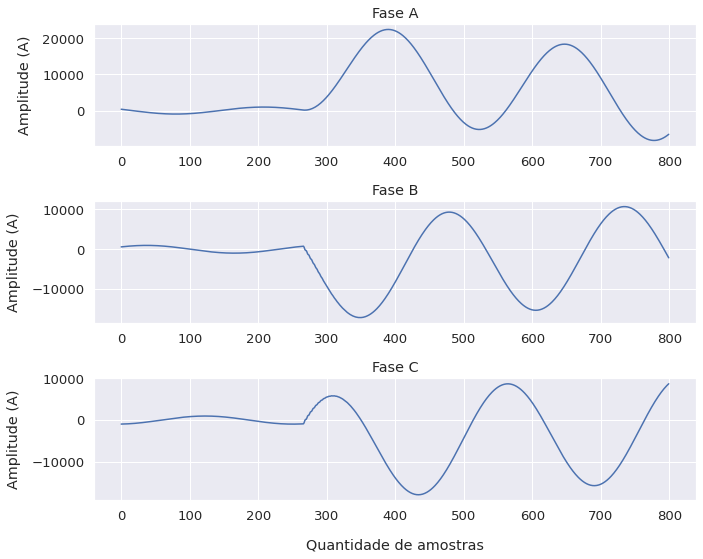

In [60]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

fig, ax = plt.subplots(figsize=(10,8), ncols=1, nrows=3)
font_size = 20

left   =  0.125  # the left side of the subplots of the figure
right  =  0.9    # the right side of the subplots of the figure
bottom =  0    # the bottom of the subplots of the figure
top    =  0.8   # the top of the subplots of the figure
wspace =  0.3     # the amount of width reserved for blank space between subplots
hspace =  0.4    # the amount of height reserved for white space between subplots

# This function actually adjusts the sub plots using the above paramters
plt.subplots_adjust(
    left    =  left, 
    bottom  =  bottom, 
    right   =  right, 
    top     =  top, 
    wspace  =  wspace, 
    hspace  =  hspace
)

# The amount of space above titles
y_title_margin = 1

ax[0].set_title("Fase A", y = y_title_margin)
ax[0].set_ylabel('Amplitude (A)', labelpad=10)
ax[1].set_title("Fase B", y = y_title_margin, )
ax[1].set_ylabel('Amplitude (A)', labelpad=10)
ax[2].set_title("Fase C", y = y_title_margin,)
ax[2].set_ylabel('Amplitude (A)', labelpad=10)
ax[2].set_xlabel('Quantidade de amostras', labelpad=15)

sns.set(font_scale=1.2)
sns.lineplot(data = ia[500:1300], ax = ax[0])
sns.lineplot(data = ib[500:1300], ax = ax[1])
sns.lineplot(data = ic[500:1300], ax = ax[2])

plt.tight_layout()
plt.savefig('corrente_data2.pdf', bbox_inches='tight')
plt.show()

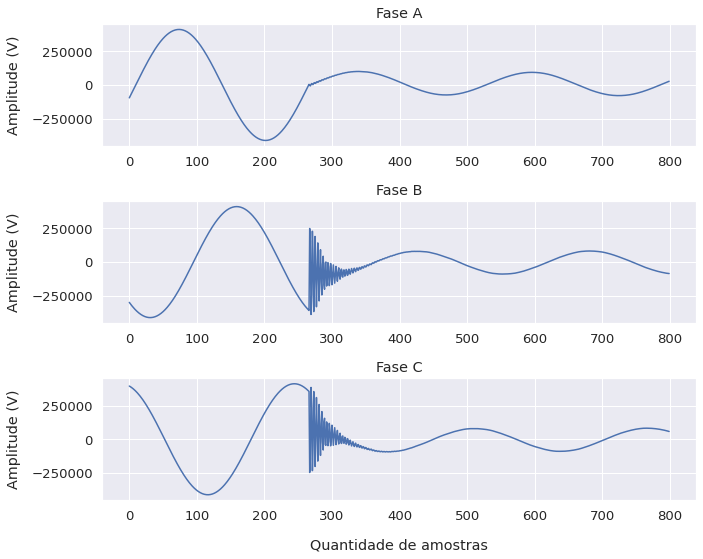

In [61]:
fig, ax = plt.subplots(figsize=(10,8), ncols=1, nrows=3)
font_size = 20

left   =  0.125  # the left side of the subplots of the figure
right  =  0.9    # the right side of the subplots of the figure
bottom =  0    # the bottom of the subplots of the figure
top    =  0.8   # the top of the subplots of the figure
wspace =  0.3     # the amount of width reserved for blank space between subplots
hspace =  0.4    # the amount of height reserved for white space between subplots

# This function actually adjusts the sub plots using the above paramters
plt.subplots_adjust(
    left    =  left, 
    bottom  =  bottom, 
    right   =  right, 
    top     =  top, 
    wspace  =  wspace, 
    hspace  =  hspace
)

# The amount of space above titles
y_title_margin = 1

ax[0].set_title("Fase A", y = y_title_margin)
ax[0].set_ylabel('Amplitude (V)', labelpad=10)
ax[1].set_title("Fase B", y = y_title_margin, )
ax[1].set_ylabel('Amplitude (V)', labelpad=10)
ax[2].set_title("Fase C", y = y_title_margin,)
ax[2].set_ylabel('Amplitude (V)', labelpad=10)
ax[2].set_xlabel('Quantidade de amostras', labelpad=15)

sns.set(font_scale=1.2)
sns.lineplot(data = va[500:1300], ax = ax[0])
sns.lineplot(data = vb[500:1300], ax = ax[1])
sns.lineplot(data = vc[500:1300], ax = ax[2])

plt.tight_layout()
plt.savefig('tensao_data2.pdf', bbox_inches='tight')
plt.show()

In [71]:
import scipy.io
path = '../data/raw_signals/sim_Chesf_500_Classifier_LOC3_ABC_20_0_1.0000.mat'
mat = scipy.io.loadmat(path)

In [72]:
mat.keys()

dict_keys(['__header__', '__version__', '__globals__', 'Fault', 'FileName', 'Files', 'Folder', 'I', 'I_L', 'L', 'LOC', 'LoadFile', 'Mul', 'Mul2', 'RealFaultTime', 'RealTime', 'Relay', 'RelayFaultTime', 'RelayTime', 'SFiles', 'V', 'V_L', 'changeFile', 'dk', 'f', 'fs', 'fs_new', 'j', 'order', 'phase', 's', 'snrdB', 'str', 't', 'time', 'tipo', 'tipo_falta', 'u', 'v_filt', 'vt'])

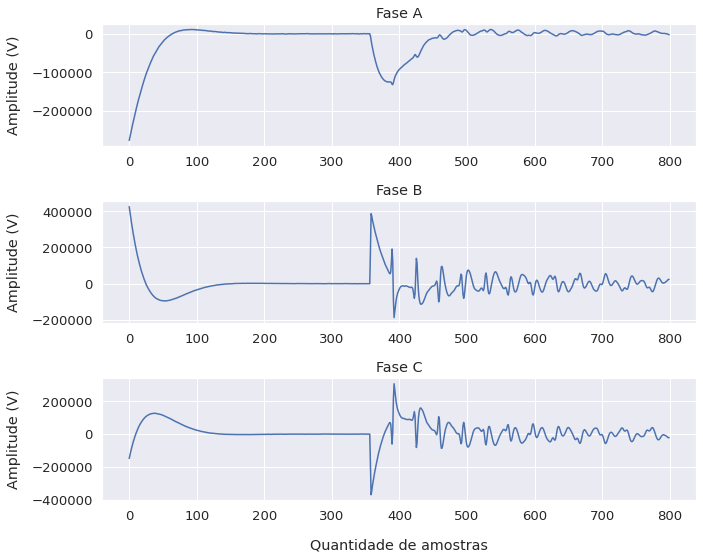

In [74]:
import seaborn as sns
from scipy import signal
sns.set_style("darkgrid")

def notch_filter(entrada, fs, f0, fatorNotch):
  w0 = 2 * np.pi * f0 / fs
  a0 = -2 * np.cos(w0)
  B = np.array([1, a0, 1])
  A = np.array([1, a0*fatorNotch, fatorNotch**2])
  entrada1 = np.hstack((entrada, entrada, entrada, entrada, entrada))
  saida1 = signal.lfilter(B, A, entrada1)
  lenSaida1 = saida1.size
  lenEntrada = entrada.size
  sinalTrans = saida1[lenSaida1-lenEntrada:lenSaida1]
  sinalFund  = entrada - sinalTrans
  return sinalFund, sinalTrans

fs = 15360  # Sample frequency (Hz)
f0 = 60.0  # Frequency to be removed from signal (Hz)
fatorNotch = 0.97

_, sa = notch_filter(mat['V'][2200:3000, 0], fs, f0, fatorNotch)
_, sb = notch_filter(mat['V'][2200:3000, 1], fs, f0, fatorNotch)
_, sc = notch_filter(mat['V'][2200:3000, 2], fs, f0, fatorNotch)

fig, ax = plt.subplots(figsize=(10,8), ncols=1, nrows=3)
font_size = 20

left   =  0.125  # the left side of the subplots of the figure
right  =  0.9    # the right side of the subplots of the figure
bottom =  0    # the bottom of the subplots of the figure
top    =  0.8   # the top of the subplots of the figure
wspace =  0.3     # the amount of width reserved for blank space between subplots
hspace =  0.4    # the amount of height reserved for white space between subplots

# This function actually adjusts the sub plots using the above paramters
plt.subplots_adjust(
    left    =  left, 
    bottom  =  bottom, 
    right   =  right, 
    top     =  top, 
    wspace  =  wspace, 
    hspace  =  hspace
)

# The amount of space above titles
y_title_margin = 1

ax[0].set_title("Fase A", y = y_title_margin)
ax[0].set_ylabel('Amplitude (V)', labelpad=10)
ax[1].set_title("Fase B", y = y_title_margin, )
ax[1].set_ylabel('Amplitude (V)', labelpad=10)
ax[2].set_title("Fase C", y = y_title_margin,)
ax[2].set_ylabel('Amplitude (V)', labelpad=10)
ax[2].set_xlabel('Quantidade de amostras', labelpad=15)

sns.set(font_scale=1.2)
sns.lineplot(data = sa, ax = ax[0])
sns.lineplot(data = sb, ax = ax[1])
sns.lineplot(data = sc, ax = ax[2])

plt.tight_layout()
plt.savefig('tensao_data1_filtered.pdf', bbox_inches='tight')
plt.show()

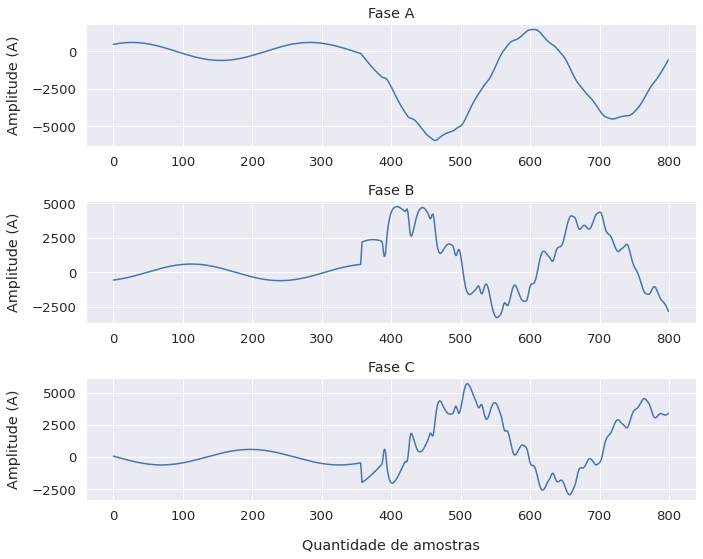

In [75]:
import seaborn as sns
sns.set_style("darkgrid")
fig, ax = plt.subplots(figsize=(10,8), ncols=1, nrows=3)
font_size = 20

left   =  0.125  # the left side of the subplots of the figure
right  =  0.9    # the right side of the subplots of the figure
bottom =  0    # the bottom of the subplots of the figure
top    =  0.8   # the top of the subplots of the figure
wspace =  0.3     # the amount of width reserved for blank space between subplots
hspace =  0.4    # the amount of height reserved for white space between subplots

# This function actually adjusts the sub plots using the above paramters
plt.subplots_adjust(
    left    =  left, 
    bottom  =  bottom, 
    right   =  right, 
    top     =  top, 
    wspace  =  wspace, 
    hspace  =  hspace
)

# The amount of space above titles
y_title_margin = 1

ax[0].set_title("Fase A", y = y_title_margin)
ax[0].set_ylabel('Amplitude (A)', labelpad=10)
ax[1].set_title("Fase B", y = y_title_margin, )
ax[1].set_ylabel('Amplitude (A)', labelpad=10)
ax[2].set_title("Fase C", y = y_title_margin,)
ax[2].set_ylabel('Amplitude (A)', labelpad=10)
ax[2].set_xlabel('Quantidade de amostras', labelpad=15)

sns.set(font_scale=1.2)
sns.lineplot(data = mat['I'][2200:3000,0], ax = ax[0])
sns.lineplot(data = mat['I'][2200:3000,1], ax = ax[1])
sns.lineplot(data = mat['I'][2200:3000,2], ax = ax[2])

plt.tight_layout()
plt.savefig('corrente_data1.pdf', bbox_inches='tight')
plt.show()

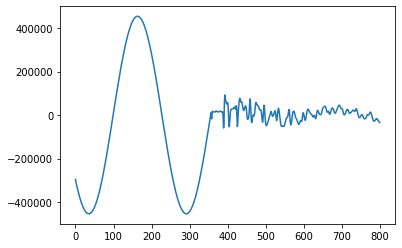

In [39]:
plt.plot(mat['V'][2200:3000,0])

In [22]:
data['V_ABC'][:,1,0,0,3,0].shape

(1537,)

In [18]:
data['I_ABC'][:,0,0,0,3,0]

array([    89.76927871,     66.03095896,     42.25373028, ...,
       -10024.71858348, -10014.10962489,  -9995.85639571])

In [16]:
# i_v = 'I'
# signal_dict = {}
# for file in files:
#     data = mat73.loadmat(file)
#     fault_type = file.split('_')[-1].split('.')[0]
#     signal = data[f'{i_v}_{fault_type}']
#     signals = []
#     for i in indexes:
#         # Adiciona ruído
#         phase = signal[:,:, i[0], i[1], i[2], i[3]]
#         noiseA = add_noise(phase[:, 0], 60)
#         noiseB = add_noise(phase[:, 1], 60)
#         noiseC = add_noise(phase[:, 2], 60)
#         three_phase_signal = np.vstack((noiseA, noiseB, noiseC)).T
#         signals.append({i[3]: three_phase_signal})
#     signal_dict[fault_type] = signals

In [17]:
# angle_dict = {}
# for i, item in enumerate(sio.loadmat(disparo)['Flt_trip']):
#     value = np.where(item[:-1] != item[1:])[0][0]
#     angle_dict[i] = value

In [ ]:
# detected_signal_dict = {}
# for key in signal_dict.keys():
#     detected_signals = []
#     for item in signal_dict[key]:
#         a = list(item.keys())[0]
#         index = angle_dict[a]
#         # Pega 1/4 pré falta e 1 ciclo pós falta
#         detected_signal = item[a][index-64:index+256]
#         detected_signals.append(detected_signal)
#     detected_signal_dict[key] = detected_signals

In [23]:
# signal_dict.keys()

dict_keys(['BCG', 'BC', 'ABG', 'CA', 'CG', 'AG', 'CAG', 'BG', 'AB', 'ABC'])

In [27]:
# signal_dict['BCG'][1].keys()

dict_keys([1])

In [9]:
# detected_signal_dict.keys()

dict_keys(['BCG', 'BC', 'ABG', 'CA', 'CG', 'AG', 'CAG', 'BG', 'AB', 'ABC'])

In [10]:
# type(detected_signal_dict['AB'])

list

In [11]:
# len(detected_signal_dict['AB'])

684

In [12]:
# def findElements(lst1, lst2):
#     return list(np.array(lst1)[lst2])

In [13]:
# train_sampled_signal_dict = {}
# test_sampled_signal_dict = {}
# for key in detected_signal_dict.keys():
#     index_value = random.sample(list(enumerate(detected_signal_dict[key])), 94)
#     indexes = []
#     values = []
#     for idx, val in index_value:
#         indexes.append(idx)
#         values.append(val)
#     train_sampled_signal_dict[key] = values
#     test_indexes = [x for x in list(range(684)) if x not in indexes]
#     test_values = findElements(detected_signal_dict[key], test_indexes)
#     test_sampled_signal_dict[key] = test_values

In [14]:
# test_sampled_signal_dict.keys()

dict_keys(['BCG', 'BC', 'ABG', 'CA', 'CG', 'AG', 'CAG', 'BG', 'AB', 'ABC'])

In [15]:
# train_sampled_signal_dict.keys()

dict_keys(['BCG', 'BC', 'ABG', 'CA', 'CG', 'AG', 'CAG', 'BG', 'AB', 'ABC'])

In [16]:
# test_sampled_signal_dict['AB'][0].shape

(320, 3)

In [17]:
# train_sampled_signal_dict['AB'][0].shape

(320, 3)

In [18]:
# len(test_sampled_signal_dict['AB'])

590

In [19]:
# len(train_sampled_signal_dict['AB'])

94

# Separação em ciclos pós falta

In [7]:
def get_distance(i):
    if i[0] == 0:
        return '20'
    elif i[0] == 1:
        return '150'
    else:
        return '280'

def get_resistance(i):
    if i[1] == 0:
        return '1'
    elif i[1] == 1:
        return '50'
    else:
        return '100'

def get_compensation(i):
    if i[2] == 0:
        return '0.4'
    elif i[2] == 1:
        return '0.5'
    elif i[2] == 2:
        return '0.6'
    else:
        return '0.7'

def get_angle(i):
    return str(i[3] * 10)


In [8]:
angle_dict = {}
for i, item in enumerate(sio.loadmat(disparo)['Flt_trip']):
    value = np.where(item[:-1] != item[1:])[0][0]
    angle_dict[i] = value

In [9]:
cycle_dict = {'1': 256, '2': 128, '4': 64, '8': 32, '16': 16, '32': 8, '64': 4, '128': 2}

In [10]:
len(indexes)

684

In [11]:
signals = []
for file in files:
    data = mat73.loadmat(file)
    fault_type = file.split('_')[-1].split('.')[0]
    signal = data[f'V_{fault_type}']
    final_dict_signal = {}
    samples = [indexes[i] for i in random.sample(range(684), 94)]
    for i in samples:
        # Realiza a detecção do sinal
        phase = signal[:,:, i[0], i[1], i[2], i[3]]
        index = angle_dict[i[3]]
        distance = get_distance(i)
        resistance = get_resistance(i)
        compensation = get_compensation(i)
        angle = get_angle(i)
        fault = fault_type.replace('G', 'T')
        final_dict_signal = {'distance': distance, 'resistance': resistance,
                             'compensation': compensation, 'angle': angle, 'fault_type': fault}

        # Subdivide sinal com ciclos pós falta
        for c, v in cycle_dict.items():
            detected_signal = phase[index-64:index+v]
            phase_a = add_noise(detected_signal[:,0], 60)
            phase_b = add_noise(detected_signal[:,1], 60)
            phase_c = add_noise(detected_signal[:,2], 60)
            phase_z = phase_a + phase_b + phase_c
            
            final_detected = np.vstack((phase_a, phase_b, phase_c, phase_z)).flatten()
            final_dict_signal.update({f'v_cycle_{c}': final_detected})

        signals.append(final_dict_signal)        

In [ ]:
# signals = []
# for file in files:
#     data = mat73.loadmat(file)
#     fault_type = file.split('_')[-1].split('.')[0]
#     signal = data[f'I_{fault_type}']
#     final_dict_signal = {}
#     for i in indexes:
#         # Realiza a detecção do sinal
#         phase = signal[:,:, i[0], i[1], i[2], i[3]]
#         print(phase.shape)
#         index = angle_dict[i[3]]
#         distance = get_distance(i)
#         resistance = get_resistance(i)
#         compensation = get_compensation(i)
#         angle = get_angle(i)
#         fault = fault_type.replace('G', 'T')
#         final_dict_signal = {'distance': distance, 'resistance': resistance,
#                              'compensation': compensation, 'angle': angle, 'fault_type': fault}

#         # Subdivide sinal com ciclos pós falta
#         for c, v in cycle_dict.items():
#             detected_signal = phase[index-64:index+v]
#             phase_a = add_noise(detected_signal[:,0], 60)
#             phase_b = add_noise(detected_signal[:,1], 60)
#             phase_c = add_noise(detected_signal[:,2], 60)
#             phase_z = phase_a + phase_b + phase_c
            
#             final_detected = np.vstack((phase_a, phase_b, phase_c, phase_z)).flatten()
#             final_dict_signal.update({f'i_cycle_{c}': final_detected})

#         signals.append(final_dict_signal)        

In [12]:
len(signals)

940

In [13]:
signals[0].keys()

dict_keys(['distance', 'resistance', 'compensation', 'angle', 'fault_type', 'v_cycle_1', 'v_cycle_2', 'v_cycle_4', 'v_cycle_8', 'v_cycle_16', 'v_cycle_32', 'v_cycle_64', 'v_cycle_128'])

In [15]:
signals[0]['v_cycle_1'].shape

(1280,)

In [20]:
signals[100]['fault_type']

'BC'

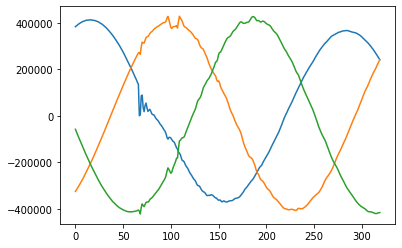

In [22]:
plt.plot(signals[500]['v_cycle_1'][:320])
plt.plot(signals[500]['v_cycle_1'][320:640])
plt.plot(signals[500]['v_cycle_1'][640:960])

In [23]:
def format_dataframe(data):
    cols = int(data.shape[0] / 4)
    shaped_data = data.reshape((4, cols)).T
    s1 = pd.Series(shaped_data[:, 0])
    s2 = pd.Series(shaped_data[:, 1])
    s3 = pd.Series(shaped_data[:, 2])
    s4 = pd.Series(shaped_data[:, 3])
    dicio = {'A': [], 'B': [], 'C': [], 'Z': []}
    dicio['A'].append(s1)
    dicio['B'].append(s2)
    dicio['C'].append(s3)
    dicio['Z'].append(s4)
    return pd.DataFrame(dicio)

In [24]:
def open_data(signal_type, cycle_name):
    data_list = []
    target_list = []
    for d in signals:
        data_list.append(format_dataframe(d[f'{signal_type}_{cycle_name}']))
        target_list.append(d['fault_type'])
    X = pd.concat(data_list).reset_index(drop=True)
    y = np.array(target_list)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y,
                                                        random_state=42, shuffle=True)
    compressed_pickle(INPUT_DATA_PATH + f'folds-robson/{signal_type}/{cycle_name}/' + 'X_train', X_train)
    compressed_pickle(INPUT_DATA_PATH + f'folds-robson/{signal_type}/{cycle_name}/' + 'y_train', y_train)
    compressed_pickle(INPUT_DATA_PATH + f'folds-robson/{signal_type}/{cycle_name}/' + 'X_val', X_test)
    compressed_pickle(INPUT_DATA_PATH + f'folds-robson/{signal_type}/{cycle_name}/' + 'y_val', y_test)
    return X_train, y_train

In [25]:
def save_folds(signal_type, cycle_name):
    X_train, y_train = open_data(signal_type, cycle_name)
    data_folds_path = INPUT_DATA_PATH + f'folds-robson/{signal_type}/{cycle_name}/'
    kf = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)
    for fold, (tr, te) in enumerate(kf.split(X_train, y_train), start=1):
        X_tr, X_te = X_train.iloc[tr, :], X_train.iloc[te, :]
        y_tr, y_te = y_train[tr], y_train[te]
        compressed_pickle(data_folds_path + f'X_train_fold_{fold}', X_tr)
        compressed_pickle(data_folds_path + f'X_test_fold_{fold}', X_te)
        compressed_pickle(data_folds_path + f'y_train_fold_{fold}', y_tr)
        compressed_pickle(data_folds_path + f'y_test_fold_{fold}', y_te)

In [26]:
cycle_list = ['cycle_1', 'cycle_2', 'cycle_4', 'cycle_8', 'cycle_16', 'cycle_32', 'cycle_64',
              'cycle_128']

for cycle_name in cycle_list:
    # save_folds('i', cycle_name)
    save_folds('v', cycle_name)

BCT


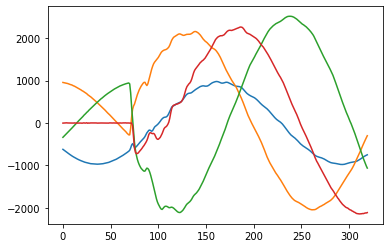

In [24]:
print(signals[0]['fault_type'])
plt.plot(signals[0]['i_cycle_1'][:320])
plt.plot(signals[0]['i_cycle_1'][320:640])
plt.plot(signals[0]['i_cycle_1'][640:960])
plt.plot(signals[0]['i_cycle_1'][960:]);

In [25]:
signals[0]['i_cycle_2'].shape

(768,)

BCT


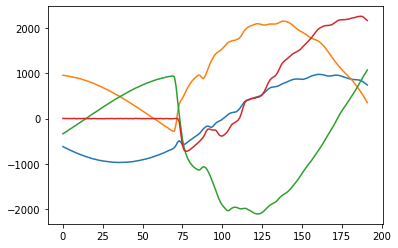

In [26]:
print(signals[0]['fault_type'])
plt.plot(signals[0]['i_cycle_2'][:192])
plt.plot(signals[0]['i_cycle_2'][192:384])
plt.plot(signals[0]['i_cycle_2'][384:576])
plt.plot(signals[0]['i_cycle_2'][576:]);